## Import

In [1]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, GlobalAveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

## GPU

In [2]:
# # Check if a GPU is available
# gpu_available = tf.config.list_physical_devices('GPU')

# if gpu_available:
#     # Set TensorFlow to use GPU
#     tf.config.experimental.set_memory_growth(gpu_available[0], True)
#     print("GPU is available and configured.")
# else:
#     print("GPU is not available.")

## Dataset, Kaggle

In [3]:
# from google.colab import files
# files.upload()

In [4]:
# !rm -r ~/.kaggle
# !mkdir ~/.kaggle
# !mv ./kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

In [5]:
# !kaggle datasets download -d dimasirfan/added-plant-dataset -p "/content/data"

### Extract Zip Dataset

In [6]:
# local_zip = '/content/data/added-plant-dataset.zip'
# zip_ref   = zipfile.ZipFile(local_zip, 'r')
# zip_ref.extractall('/content')
# zip_ref.close()

## Create The Model
Model is build in Transfer Learning using MobileNetV2 for efficiency purposes

In [7]:
source_path = 'data/Plant Disease/New Plant Diseases Dataset'
train_path = os.path.join(source_path, "train")
valid_path = os.path.join(source_path, "valid")

In [23]:
image_size = (224, 224)
batch_size = 32

In [11]:
base_model = tf.keras.applications.MobileNetV2(
    include_top=False, 
    weights='imagenet', 
    input_shape=(image_size[0], image_size[1], 3),
)
for layer in base_model.layers:
    layer.trainable = False

In [12]:
# Preprocess the input images and apply augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.5,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [13]:
# Create train and validation data generators
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle = True
)

validation_generator = valid_datagen.flow_from_directory(
    valid_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle = False
)


Found 71020 images belonging to 54 classes.
Found 17692 images belonging to 54 classes.


#### Define The Model in GPU Runtime

In [14]:
with tf.device("GPU"):
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(54, activation='softmax'))

# Compile the model
learning_rate = 0.005
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_2 (Dense)             (None, 512)               524800    
                                                                 
 dense_3 (Dense)             (None, 54)                2

#### Defining All Callbacks Needed
Define the checkpoint, early stopping, and reduce learning rate callbacks

In [15]:
checkpoint_callback = ModelCheckpoint('model_weights.h5', save_best_only=True, save_weights_only=True)
early_stopping_callback = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)
reduce_lr_callback = ReduceLROnPlateau(factor=0.1, patience=3, monitor='val_loss')

#### Train The Model


In [16]:
epoch = 5
with tf.device('GPU'):
    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epoch,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]
    )

Epoch 1/5
1110/1110 [==============================] - 1919s 2s/step - loss: 0.8861 - accuracy: 0.7417 - val_loss: 0.5677 - val_accuracy: 0.8301 - lr: 0.0050
Epoch 2/5
1110/1110 [==============================] - 1860s 2s/step - loss: 0.5621 - accuracy: 0.8341 - val_loss: 0.5186 - val_accuracy: 0.8575 - lr: 0.0050
Epoch 3/5
1110/1110 [==============================] - 1910s 2s/step - loss: 0.5074 - accuracy: 0.8533 - val_loss: 0.4452 - val_accuracy: 0.8723 - lr: 0.0050
Epoch 4/5
1110/1110 [==============================] - 1985s 2s/step - loss: 0.4837 - accuracy: 0.8616 - val_loss: 0.5019 - val_accuracy: 0.8637 - lr: 0.0050
Epoch 5/5
1110/1110 [==============================] - 3334s 3s/step - loss: 0.4704 - accuracy: 0.8681 - val_loss: 0.4527 - val_accuracy: 0.8717 - lr: 0.0050


## Save Model n Convert to TFLite

In [17]:
export_dir = 'saved_model/1'
tf.saved_model.save(model, export_dir)

INFO:tensorflow:Assets written to: saved_model/1\assets


INFO:tensorflow:Assets written to: saved_model/1\assets


In [18]:
mode = "Storage" 

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

In [19]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Invoke the converter to finally generate the TFLite model
tflite_model = converter.convert()

In [21]:
import pathlib
tflite_model_file = pathlib.Path('./plants_disease.tflite')
tflite_model_file.write_bytes(tflite_model)

5431296

## Plot The Result

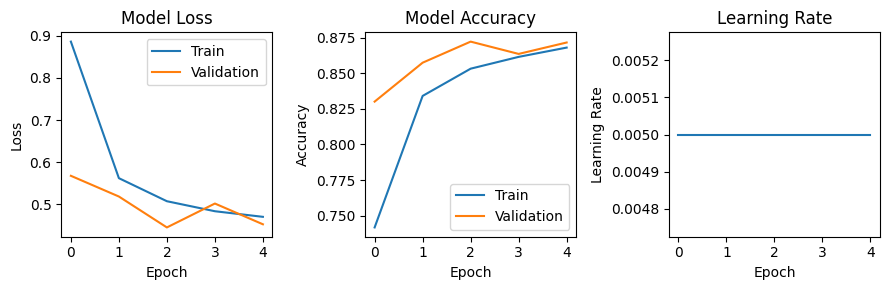

In [24]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
fig, axes = plt.subplots(1, 3, figsize=(9, 3))

axes[0].plot(history.history['loss'])
axes[0].plot(history.history['val_loss'])
axes[0].set_title('Model Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend(['Train', 'Validation'], loc='upper right')

axes[1].plot(history.history['accuracy'])
axes[1].plot(history.history['val_accuracy'])
axes[1].set_title('Model Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend(['Train', 'Validation'], loc='lower right')

axes[2].plot(history.history['lr'])
axes[2].set_title('Learning Rate')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Learning Rate')

plt.tight_layout()
plt.show()